# Sampling Fram Bridges - SBB Project


In [36]:
from skopt.sampler import Lhs, Sobol
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import time
import math as m

### Problem Definition

Input Parameter/ Deisgn Features:
- b1: Length of Wall 1 [m]: 5,35
- b2:

## Utils

In [37]:

def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        try:
            os.makedirs(folder_path)
            print(f"Folder '{folder_path}' created successfully.")
        except OSError as e:
            print(f"Error creating folder '{folder_path}': {e}")

In [38]:
def hist_matrix(df, n_cols=4, bins=20, color='gray', edgecolor='darkgray'):
    # Number of columns in the DataFrame
    n_columns = len(df.columns)

    # Number of histogram columns per row
    n_cols = 4

    # Calculate the number of rows needed
    n_rows = m.ceil(n_columns / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2.5))  # Adjust the figsize as needed
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        # Plot histogram on the corresponding subplot
        axes[i].hist(df[column], bins=bins, color=color, edgecolor=edgecolor)  # You can customize the histogram here
        axes[i].set_title(f'Histogram of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(False)  # Optional: Remove grid lines

    # Hide any empty subplots if the number of columns is less than n_rows*n_cols
    for ax in axes[len(df.columns):]:
        ax.axis('off')

    plt.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.show()  # Display the histograms

## Sampling

In [39]:
n_samples=1000 #number of samples that should be generated
idx_s=202 # Smapling iteration


In [40]:
# Save idx_s in a CSV file (as comunication with GH) + create folders

# create path relative to yurrent directory (=the directory of the notebook file)
current_directory = os.getcwd()
folder_name='CFBData'
folder_path = os.path.join(current_directory, folder_name)

# define/check/ create main folder
#folder_path='C:\CFBData'

create_folder_if_not_exists(folder_path)
#TODO deleate all subfolders in that folder

# check/ create subfolder
subfolder = '{}_Batch'.format(idx_s)
subfolder_path = folder_path+ '\\' +subfolder
create_folder_if_not_exists(subfolder_path)

# create subfolders for each bridge
for i in range(n_samples):
    indiv_path= subfolder_path + '\\{}_{}_CFB'.format(idx_s,i)
    create_folder_if_not_exists(indiv_path)
# # create file with sampling iteration index (functioning as communication file)
# idx_file = subfolder_path + '\current_idx_s.csv'
# df_idx_s = pd.DataFrame([idx_s], columns=['idx_s'])
# df_idx_s.to_csv(idx_file, index=False)  # Save idx_s CSV file

In [42]:
# define file path
#folder= 'C:\\Temp\\00_Sampled'


# define ranges of design parameter
#----- geometric parameter (global) --------
# Main geometry
L =  (2000.,18000.)     # Span [mm]
b1 = (8000.,20000.)     # With of Wall 1 [mm]
t_p = (200.,1200.)      # Plate Thickness [mm]

t_w = (200., 1200.)    # Wall Thickness [mm]
h_w = (2000.,5000.)    # Wall Hight [mm]


main_names = ['L','b1','t_p','t_w','h_w']
main=[L,b1,t_p,t_w,h_w]


#----- geometric parameter per section ---------
# Reinforcement diamater and spacing

#plate
d1_plate= (10,12,14,16,18,20,22,26,30) # Reinforcement Diameter of all plate sections - Layer 1 (lowest layer) [mm]
d1_plate=(10.,30.)
# (10,12,14,16,18,20,22,26,30) (10.,30.)
d4_plate= (10,12,14,16,18,20,22,26,30) # Reinforcement Diameter of all plate sections - Layer 4 (top layer) [mm]
d4_plate=(10.,30.)
# (10,12,14,16,18,20,22,26,30) (10.,30.)
d2_plate= (10,12,14,16,18,20,22,26,30) # Reinforcement Diameter of all plate sections - Layer 2 (lower inner layer) [mm]
d2_plate=(10.,30.)


s_plate= (75,100,150,200,250) # Reinforcement Spacing of plate  - all Layers [mm]
s_plate=(100.,500.)
#(75,100,150,200,250)(75,250)

#walls
d1_walls= (10,12,14,16,18,20,22,26,30) # Reinforcement Diameter of all wall sections - Layer 1 (inner layer) [mm]
d1_walls=(10.,30.)
# (10,12,14,16,18,20,22,26,30)
d4_walls= (10,12,14,16,18,20,22,26,30) # Reinforcement Diameter of all wall sections - Layer 4 (outer layer) [mm]
d4_walls=(10.,30.)
# (10,12,14,16,18,20,22,26,30)
s_walls= (75,100,150,200,250) # Reinforcement Spacing of walls  - all Layers [mm]
s_walls=(100.,500.)
#(75,100,150,200,250)


reinf=[d1_plate, d4_plate, d2_plate, s_plate, d1_walls, d4_walls, s_walls]
reinf_names = ['d1_plate','d4_plate', 'd2_plate', 's_plate','d1_walls','d4_walls','s_walls']



#----- material parameter--------

# concrete parameter (at first constant for whole structure)
# sampling of fcd --> fck berechnen und dann ecu
fcc = (25.,50.) # fck [MPa] taken from EN 1992-1-1:2004 (Table 3.1) (charakteristischer Wert der Zylinderdruckfestigkeit)
# (40,45,50,55, 60,70,80,90) chosen continous as for exiting structured there could be material tests

# ecu is calculated based on fcc (after sampling, see below)

# steel
fsy = (300., 450.) # MPa / N/mm2 Fliessgrenze von Betonstahl (chosen continous as for exiting structured there could be material tests)
#fsu_fac = (1.0, 2.0) # larger than fsy, but continously larger (--> daher sample ich mit einem Faktor)
# fsu = (850., 850.001) # Duktilitätsgrenze

          
          
matPar = [fcc, fsy]
matPar_names = ['fcc', 'fsy']


# ----- loading parameter -----------
s = (0.1, 0.9) # Distance factor of railway track
beta = (-50., 50.) # angle of railway track


loadPar = [s, beta]
loadPar_names = ['s', 'beta']


In [23]:
# idea make a sample space library (dict) 
#sodass man diesen nicht immer neu definieren muss (da es so viele Parameter sind ist das extrem nerfig)
# und es sollte leich sein andere sampling methoden (gleiche b1 =b2 oder einheitliche bewehrung zu samplen, oder gerade sections)
# bei schrägen brücken auch oft gerade sections unterteilungen. zurzeit nicht so einfach möglich so zu samplem
# aber mann kann tioretisch berechnen wie gross dann die anderen parameter sein müssen abhängig von b1 und b2 
# oder man kann die prior brücken parameter nehmen und aus der verteilung samplen...

# lieber mach ich pakete die man zusammenaddieren kann?

In [24]:
# define deisgn feature space
space =  main + reinf +matPar + loadPar
space_names = main_names  + reinf_names +matPar_names + loadPar_names

# space = [t_p]
# space_names = ['t_p',]

print(space)
print(space_names)
print(len(space_names))

[(2000.0, 18000.0), (8000.0, 20000.0), (200.0, 1200.0), (200.0, 1200.0), (2000.0, 5000.0), (10.0, 30.0), (10.0, 30.0), (10.0, 30.0), (100.0, 500.0), (10.0, 30.0), (10.0, 30.0), (100.0, 500.0), (25.0, 50.0), (300.0, 450.0), (0.1, 0.9), (-50.0, 50.0)]
['L', 'b1', 't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 'd2_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 'fsy', 's', 'beta']
16


In [25]:
sampler=Sobol()
sampler.generate(space, n_samples,random_state=None)


c:\Users\kuhnso\AppData\Local\anaconda3\envs\strucenglib3\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1000=1000. 
  warnings.warn("The balance properties of Sobol' points require "


[[3772.610270228517,
  19985.219184233076,
  778.3284517448476,
  322.771193616117,
  2429.0961665592404,
  27.975872238035386,
  29.450567456554534,
  26.191108212388496,
  251.78866847954907,
  23.275072572127716,
  22.049161509480758,
  178.30093659820227,
  47.05669924795863,
  402.61450325748285,
  0.7967083296984402,
  1.6359501360209237],
 [11772.610270228517,
  13985.219184233076,
  278.3284517448477,
  822.771193616117,
  3929.0961665592404,
  17.975872238035386,
  19.450567456554534,
  16.191108212388492,
  451.7886684795491,
  13.275072572127717,
  12.049161509480758,
  378.30093659820227,
  34.55669924795863,
  327.6145032574828,
  0.3967083296984403,
  -48.36404986397906],
 [15772.610270228517,
  10985.219184233076,
  528.3284517448477,
  572.771193616117,
  4679.09616655924,
  12.975872238035384,
  24.450567456554534,
  11.191108212388494,
  351.7886684795491,
  18.27507257212772,
  27.049161509480758,
  478.30093659820227,
  28.306699247958633,
  365.1145032574828,
  0.1

In [43]:

# generate Samples - LHS
lhs=Lhs(lhs_type='classic', criterion='maximin', iterations=1000)
X=lhs.generate(space, n_samples, random_state=None)

# # generate Samples - Sobol --> Sample Space has to have less than 40 variables)
# sobol=Sobol()
# X=sobol.generate(space, n_samples, random_state=None)

# tranform into datafram
df_x=pd.DataFrame(X)
df_x.columns =  space_names # renaming columns

df_x.head(10)

,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,d2_plate,s_plate,d1_walls,d4_walls,s_walls,fcc,fsy,s,beta
0,10237.268214,14834.399248,860.878454,435.353855,2202.427476,12.801724,27.465036,14.536861,332.007571,18.963111,16.690677,458.363457,47.364371,325.167476,0.164157,1.034878
1,2020.866421,11347.521058,479.491517,1056.979078,4216.925774,26.293297,23.093134,23.108908,423.011029,27.638340,16.554950,412.345768,34.104540,317.690257,0.523638,-39.583961
2,2247.614839,13155.534258,865.121700,659.960579,4404.499813,19.553471,13.311273,24.360401,449.056705,16.108650,12.542291,231.047057,42.523199,408.929295,0.458194,14.988158
3,17834.490999,12505.083391,237.131692,204.752483,2489.837451,12.932457,10.161537,23.390086,151.423907,17.357372,16.123516,350.920399,37.437540,426.992469,0.397127,48.148932
4,12158.683579,19690.110852,711.777502,812.985956,4958.360229,10.088766,12.246357,29.774884,126.379682,14.243466,16.819461,274.858439,47.634285,433.457113,0.734111,5.514080
5,17689.550034,15117.149686,894.150928,846.953850,4539.089352,27.855203,19.699838,26.586294,369.560720,13.648347,21.891044,422.690156,31.359288,447.878394,0.563473,26.122378
6,10174.265419,19337.396281,257.243968,1112.765766,2221.478629,23.403258,17.460086,18.093234,314.020741,21.348882,10.238867,207.624966,28.305848,381.158948,0.464601,-26.908100
7,13758.751719,18231.082573,696.275465,1194.129465,4041.600691,11.107549,21.407627,11.118381,146.266113,19.776409,27.363573,437.595648,41.476193,386.526225,0.395231,14.096050
8,11799.252291,14794.793917,244.254167,1027.990517,3775.978740,27.198051,11.032057,14.259701,222.264356,24.918722,19.832737,201.298193,25.160478,417.923016,0.270979,47.072186
9,15840.762697,12110.852346,1131.337457,399.721637,4032.904925,28.152356,14.685329,11.944595,116.210954,26.890398,15.415115,111.086419,26.379237,342.257747,0.446688,4.311716


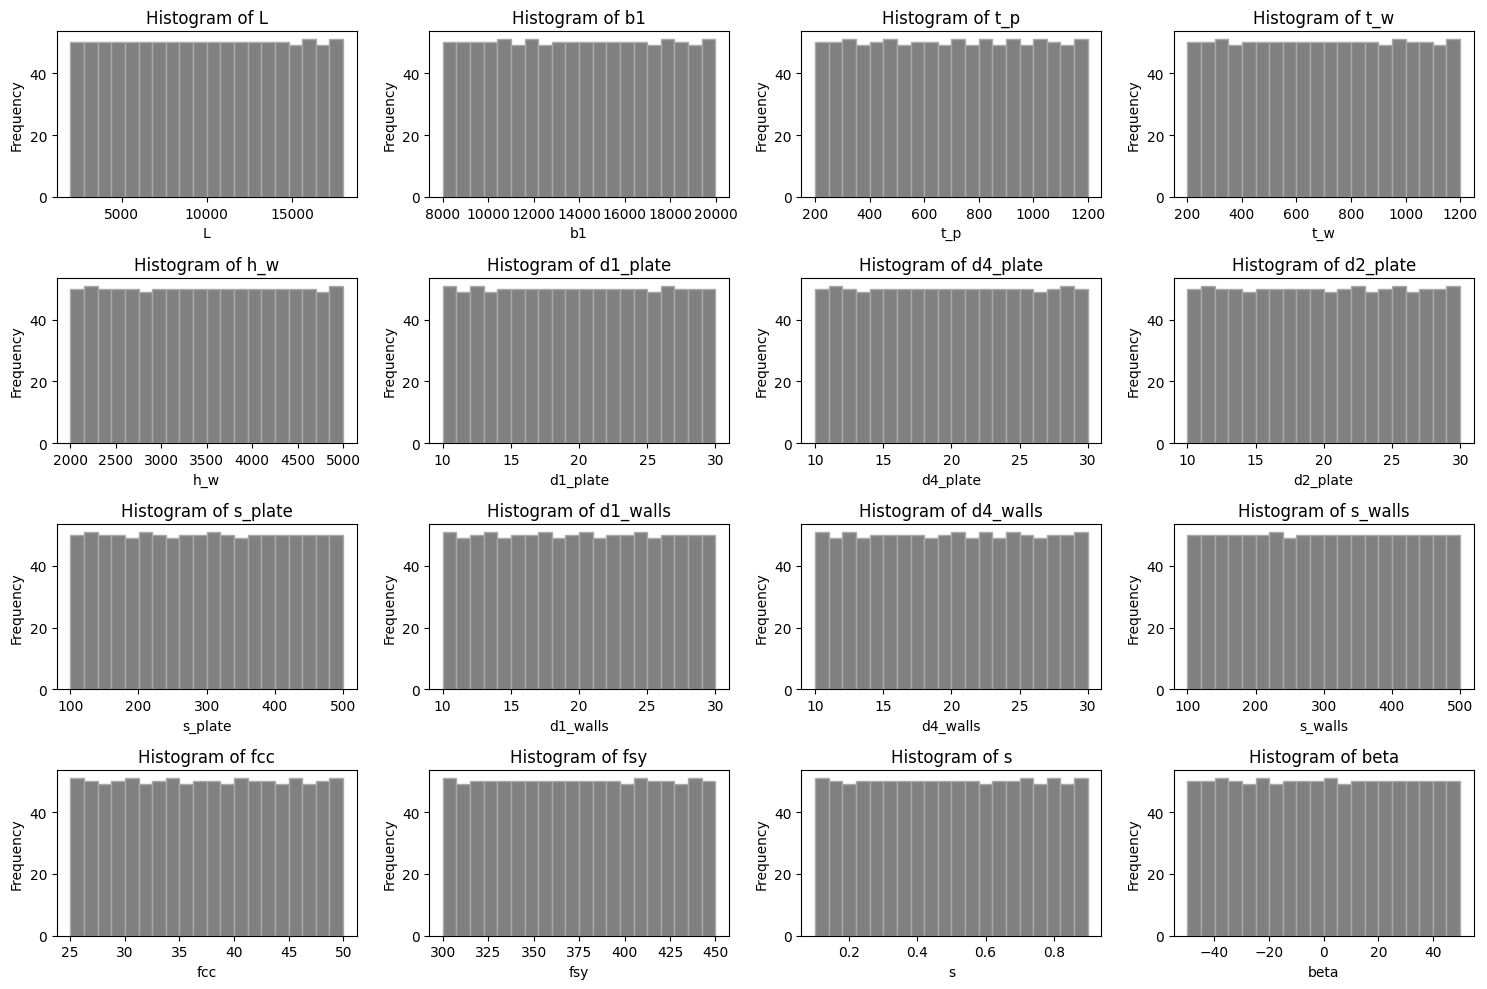

In [44]:
hist_matrix(df_x, n_cols=4, bins=20, color='gray', edgecolor='darkgray')

In [28]:
#!!! Run when 1D data generation
# Generate ordered samples
v=np.linspace(L[0], L[1], n_samples)
df_v=pd.DataFrame(v, columns=['L'])
df_v

,L
0,2000.000000
1,2016.016016
2,2032.032032
3,2048.048048
4,2064.064064
...,...
995,17935.935936
996,17951.951952
997,17967.967968
998,17983.983984


In [29]:
# define a specific sample to be caluclated
hero_parameters = {
    'L': 5800,
    'b1': 9720,
    't_p': 400,
    't_w': 400,
    'h_w': 2580,
    'd1_plate': 24,
    'd4_plate': 24,
    'd2_plate':12,
    's_plate': 200,
    'd1_walls': 14,
    'd4_walls': 24,
    's_walls': 200,
    'fcc': 12.8,
    'fsy': 390,
    'fsu_fac': 1.08,
    's': 0.18179012,
    'beta': 5
}


#!!!! Run this only when single bridge
# Convert the dictionary to a DataFrame
# hero_parameters = {key: [value] for key, value in hero_parameters.items()}
# df_x = pd.DataFrame(hero_parameters)#, columns=list(hero_parameters.keys()))

# # Print the DataFrame
# df_x

In [30]:
#!!!! Only run if 1D parameter study
# create multiple samples with only one variable varied
df_v
for key in hero_parameters.keys():
    df_v[key]=hero_parameters[key]
df_x=df_v
df_x

,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,d2_plate,s_plate,d1_walls,d4_walls,s_walls,fcc,fsy,fsu_fac,s,beta
0,5800,9720,400,400,2580,24,24,12,200,14,24,200,12.8,390,1.08,0.18179,5
1,5800,9720,400,400,2580,24,24,12,200,14,24,200,12.8,390,1.08,0.18179,5
2,5800,9720,400,400,2580,24,24,12,200,14,24,200,12.8,390,1.08,0.18179,5
3,5800,9720,400,400,2580,24,24,12,200,14,24,200,12.8,390,1.08,0.18179,5
4,5800,9720,400,400,2580,24,24,12,200,14,24,200,12.8,390,1.08,0.18179,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5800,9720,400,400,2580,24,24,12,200,14,24,200,12.8,390,1.08,0.18179,5
996,5800,9720,400,400,2580,24,24,12,200,14,24,200,12.8,390,1.08,0.18179,5
997,5800,9720,400,400,2580,24,24,12,200,14,24,200,12.8,390,1.08,0.18179,5
998,5800,9720,400,400,2580,24,24,12,200,14,24,200,12.8,390,1.08,0.18179,5


In [31]:
# Make it easyer to do these 3 options: Sampler with lhc/ sobol with alot of paramters, line space sampling for one parameter, Define all variables for a sample

# TODO: idea to make sampling cleaner: write a function that does the sampling, the defining of constants in the background,
# define a dict with all possible parameters and their ranges
# default sample everything (maybe ability presetting Step 1.1. etc)
# can provide reduced list of parameters
# can also provide a dict with fixed parameters (which are then excluded from samling)
# also a way to set some parameters equivalent to other parameters after sampling
# some are calculated after sampling
# should always return df in same column order (for that we however we need to fix the columns add I think I will add more for step 1.3)

In [45]:
# Materialkennwerte berechnen

# Concrete
# calculate dependent parameters
# fcc: Compressive strength of concrete
# ecu: Ultimate compressive strain in the concrete
def ecu_calc(fccs): # EN 1992-1-1:2004 (Table 3.1)
    return fccs.apply(lambda fcc: -0.002 if fcc <= 50 else ((2.0+0.085*(fcc-50)**(0.53)) *-0.001))

df_x['ecu']=ecu_calc(df_x['fcc']) 

# Reinforcement
df_x['fsu']=1.08*df_x['fsy']
#df_x['fsu']=df_x['fsu_fac']*df_x['fsy'] #calculate fsu with sampled fsu factor multiplied with fsy

#print
df_x[['fcc','ecu','fsy','fsu']]

,fcc,ecu,fsy,fsu
0,47.364371,-0.002,325.167476,351.180874
1,34.104540,-0.002,317.690257,343.105478
2,42.523199,-0.002,408.929295,441.643639
3,37.437540,-0.002,426.992469,461.151867
4,47.634285,-0.002,433.457113,468.133682
...,...,...,...,...
995,40.835411,-0.002,300.930281,325.004703
996,32.223417,-0.002,372.564577,402.369743
997,31.236083,-0.002,304.609981,328.978779
998,33.768889,-0.002,360.464254,389.301394


In [46]:
#define constant design variables for phase 1
# we still save all of these constant variables in the data set, to ensure: when we extend the model,
# we know these variables for each sample and combine the samples.

#----- geometric parameter (global) --------
# Main geometry
df_x['b2']=df_x['b1'] # With of Wall 2 [mm]
df_x['alpha_l']=90  # Plate Angle [Degree]

#plate parameter
df_x['l_sec'] = 0.33    # Proportion of outter plate sections [-]
# (0.1,0.45)

df_x['b_sec1_b1'] = 0.33 # Proportion of section 1 (wall 1 side) [-]
df_x['b_sec2_b1'] = 0.33 # Proportion of section 2 (wall 1 side) [-]
df_x['b_sec1_b2'] = df_x['b_sec1_b1'] # Proportion of section 1 (wall 2 side) [-]
df_x['b_sec2_b2'] = df_x['b_sec1_b2'] # Proportion of section 2 (wall 2 side) [-]
#(0.05,0.45)

# wall paraeter
df_x['h_S1_3'] = 0.33   # Proportion of wall section (upper)
df_x['h_S7_9'] = 0.33   # Proportion of wall section (lower)
#(0.05,0.45)

# vouten and parapet geometry parameter
df_x['h_v'] = 0       # Hight of Voute  [mm]
df_x['l_v'] = 0     # Length of Voute  [mm]

df_x['left_p'] = False   #Parapet on the left (at x=0)
df_x['right_p'] = False  #Parapet on the right (at x=b1)
df_x['h_b'] = 0        #Parapet height (Bruestungshöhe) [mm]
df_x['b_b'] = 0      # Parapet width [mm]


# vouPar_names = ['h_v','l_v','left_p','right_p','h_b','b_b']
# vouPar = [h_v,l_v,left_p,right_p,h_b,b_b]



#----- material parameter--------

df_x['esu'] = 0.045 # ultimate reinforcement strain [-]


#----- load parameter--------
df_x['h_G'] = 1000 #Gravel layer hight [mm]
df_x['gamma_E'] =0.00002 #spez. weight of backfill [N/mm3]
df_x['phi_k'] = 30 # friction angle [Degree]

df_x['q_Gl'] = 4.8+1.7 # Load of concrete sleeper (Betonschwelle) and rail track [N/mm]
df_x['b_Bs']= 2500 # width of concrete sleeper (Betonschwelle) [mm]
df_x['Q_k'] = 225000 # norminal axle load (dependent on the class, acc. to SIA 269/1 11.2, for D4 = 225 [N] )


# ---- structural modeling parameters -------
df_x['withMPCs'] = True     # with or without MPCs
df_x['offsetmodeling'] = True  #with or without offsetmodeling
df_x['mesh_size_factor'] = 3  # mesh_size_factor (multiplied with t_p or t_w respectively)

In [47]:
#----- reinforcement --------
# define constant variables

df_x['oo'] = 30 # upper reinforcement cover [mm]
df_x['uu'] = 30 # lower reinforcement cover [mm]


#reinf=[d1_plate, d4_plate, s_plate, d1_walls, d4_walls, s_walls]

#plate
#df_x['d2_plate'] = 12 # Reinforcement Diameter of all plate sections - Layer 2 (lower middle layer) [mm]
df_x['d3_plate'] = 12 # Reinforcement Diameter of all plate sections - Layer 3 (upper middle layer) [mm]
# walls
df_x['d2_walls'] = 12 # Reinforcement Diameter of all wall sections - Layer 2 (inner middle layer) [mm]
df_x['d3_walls'] = 12 # Reinforcement Diameter of all wall sections - Layer 3 (outer middle layer) [mm]






C:\Users\kuhnso\AppData\Roaming\Python\Python39\site-packages\matplotlib\axes\_axes.py:6639: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


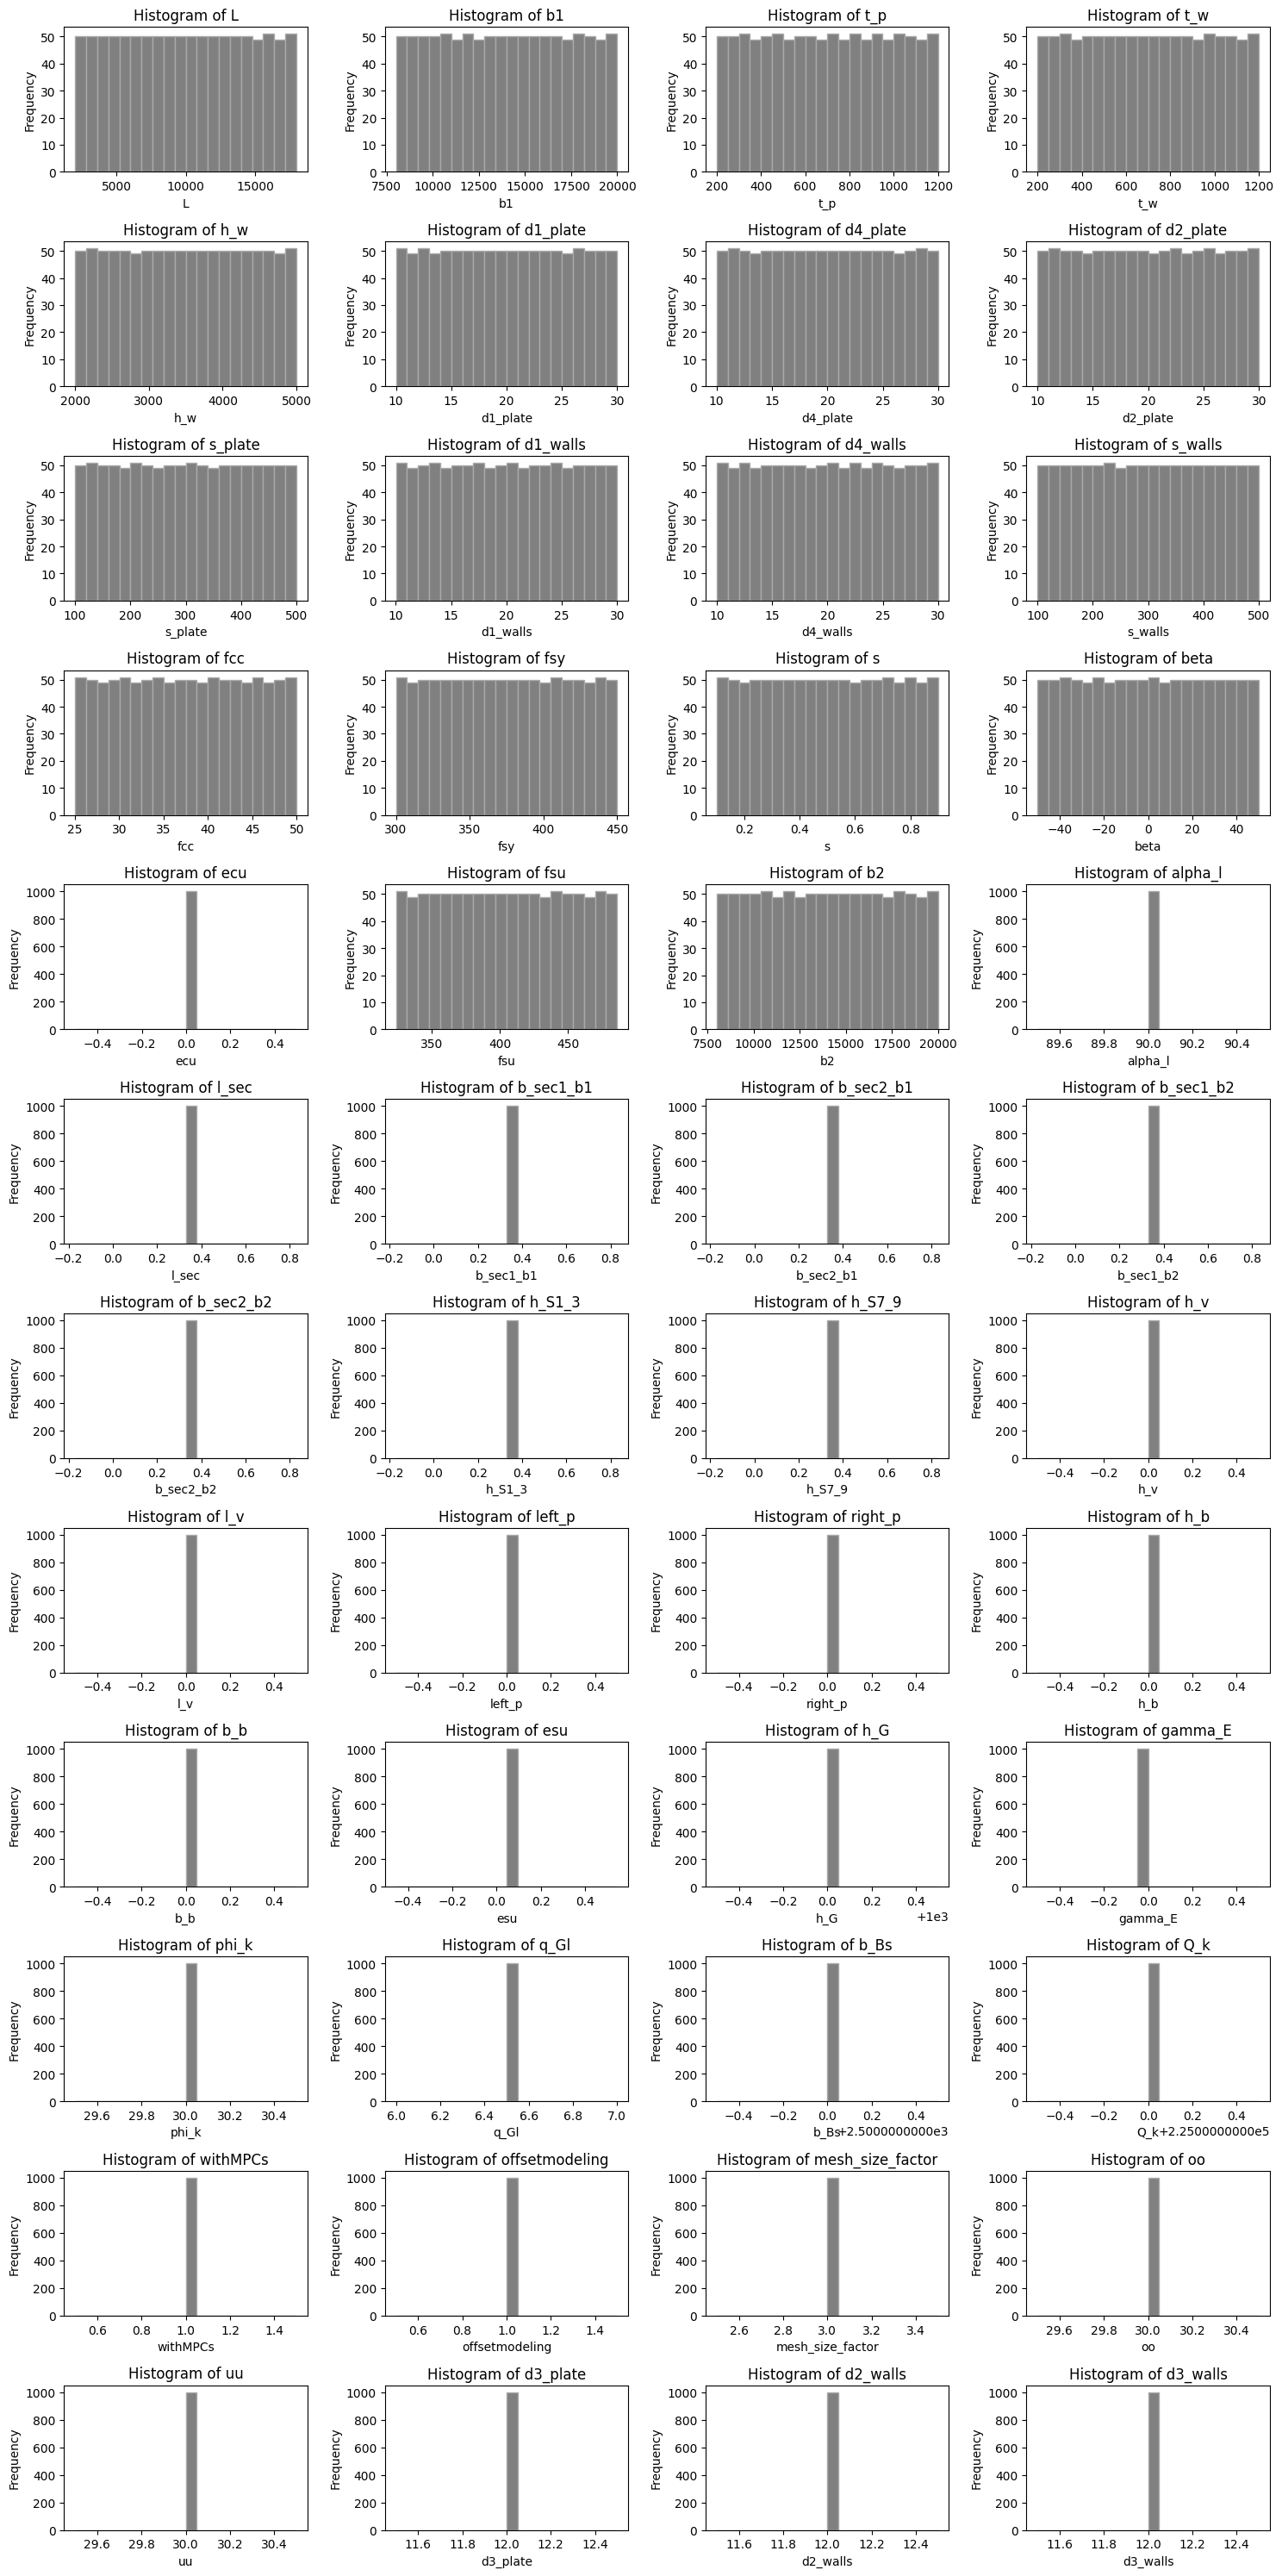

In [48]:
hist_matrix(df_x, n_cols=4, bins=20, color='gray', edgecolor='darkgray')

In [117]:
# # assign the reinforcements for each individual section
# for i in range (1,9+1):
#     print('i',i)
#     # plate
#     df_x['d1_plate_s{}'.format(i)]=df_x['d1_plate']
#     df_x['d2_plate_s{}'.format(i)]=df_x['d2_plate']
#     df_x['d3_plate_s{}'.format(i)]=df_x['d3_plate']
#     df_x['d4_plate_s{}'.format(i)]=df_x['d4_plate']
    
#     df_x['s1_plate_s{}'.format(i)]=df_x['s_plate']
#     df_x['s2_plate_s{}'.format(i)]=df_x['s_plate']
#     df_x['s3_plate_s{}'.format(i)]=df_x['s_plate']
#     df_x['s4_plate_s{}'.format(i)]=df_x['s_plate']
    
#     #walls
#     df_x['d1_walls_s{}'.format(i)]=df_x['d1_walls']
#     df_x['d2_walls_s{}'.format(i)]=df_x['d2_walls']
#     df_x['d3_walls_s{}'.format(i)]=df_x['d3_walls']
#     df_x['d4_walls_s{}'.format(i)]=df_x['d4_walls']
    
#     df_x['s1_walls_s{}'.format(i)]=df_x['s_walls']
#     df_x['s2_walls_s{}'.format(i)]=df_x['s_walls']
#     df_x['s3_walls_s{}'.format(i)]=df_x['s_walls']
#     df_x['s4_walls_s{}'.format(i)]=df_x['s_walls']

In [118]:
# # constante bewehrung definieren

# # set all reinforcements in plate and walls equal to first section reinforcement
# # so no 9 different reinforcements but only one reinforcement defined for plate, wall1, wall2
# for i in range(2,9+1): # i goes from 2 to 9
#     str_o='d_p_{}_o'.format(i)
#     df_x[str_o]= df_x['d_p_1_o']
#     str_i='d_p_{}_i'.format(i)
#     df_x[str_i]= df_x['d_p_1_i']
    
#     str_o='s_p_{}_o'.format(i)
#     df_x[str_o]= df_x['s_p_1_o']
#     str_i='s_p_{}_i'.format(i)
#     df_x[str_i]= df_x['s_p_1_i']
    
    
#     str_o='d_w1_{}_o'.format(i)
#     df_x[str_o]= df_x['d_w1_1_o']
#     str_i='d_w1_{}_i'.format(i)
#     df_x[str_i]= df_x['d_w1_1_i']
    
#     str_o='s_w1_{}_o'.format(i)
#     df_x[str_o]= df_x['s_w1_1_o']
#     str_i='s_w1_{}_i'.format(i)
#     df_x[str_i]= df_x['s_w1_1_i']
    
    
#     str_o='d_w2_{}_o'.format(i)
#     df_x[str_o]= df_x['d_w2_1_o']
#     str_i='d_w2_{}_i'.format(i)
#     df_x[str_i]= df_x['d_w2_1_i']
    
#     str_o='s_w2_{}_o'.format(i)
#     df_x[str_o]= df_x['s_w2_1_o']
#     str_i='s_w2_{}_i'.format(i)
#     df_x[str_i]= df_x['s_w2_1_i']





In [119]:
## TODO sort the columns in corect order (Does it change for next parameter studie steps?)

# save as csv

In [49]:
# save vectors in one csv file
p_file=subfolder_path+'\{}_CFBSamples.csv'.format(idx_s)
df_x.to_csv(p_file,index=True) # Save csv file

In [50]:
# save x.txt in specific subfolder
# for i in 
for i in range(len(df_x)):
    file_path=subfolder_path + '\\{}_{}_CFB\\x.csv'.format(idx_s,i)
    df_x.iloc[i].to_csv(file_path)



In [51]:
df_x

,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,d2_plate,s_plate,d1_walls,...,b_Bs,Q_k,withMPCs,offsetmodeling,mesh_size_factor,oo,uu,d3_plate,d2_walls,d3_walls
0,10237.268214,14834.399248,860.878454,435.353855,2202.427476,12.801724,27.465036,14.536861,332.007571,18.963111,...,2500,225000,True,True,3,30,30,12,12,12
1,2020.866421,11347.521058,479.491517,1056.979078,4216.925774,26.293297,23.093134,23.108908,423.011029,27.638340,...,2500,225000,True,True,3,30,30,12,12,12
2,2247.614839,13155.534258,865.121700,659.960579,4404.499813,19.553471,13.311273,24.360401,449.056705,16.108650,...,2500,225000,True,True,3,30,30,12,12,12
3,17834.490999,12505.083391,237.131692,204.752483,2489.837451,12.932457,10.161537,23.390086,151.423907,17.357372,...,2500,225000,True,True,3,30,30,12,12,12
4,12158.683579,19690.110852,711.777502,812.985956,4958.360229,10.088766,12.246357,29.774884,126.379682,14.243466,...,2500,225000,True,True,3,30,30,12,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15979.531619,11157.472159,613.352881,1050.695774,4361.665034,21.327661,22.248412,29.724917,198.579963,19.849610,...,2500,225000,True,True,3,30,30,12,12,12
996,8825.943582,19825.690327,954.314759,1043.016468,2409.178399,11.804836,19.193179,29.618008,169.995761,25.684291,...,2500,225000,True,True,3,30,30,12,12,12
997,14943.982198,15392.069179,1163.475426,612.109396,3408.202542,20.642685,24.816781,20.964564,229.725113,21.219275,...,2500,225000,True,True,3,30,30,12,12,12
998,5260.829947,19442.021593,989.647806,212.157806,3475.887856,27.573015,25.226641,24.359206,262.045038,26.416170,...,2500,225000,True,True,3,30,30,12,12,12


# View Samples
#space_names= main_names + vouPar_names + matPar_names + p_ds_names + w1_ds_names + w2_ds_names

In [51]:
df_x

,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,s_plate,d1_walls,d4_walls,...,s3_plate_s9,s4_plate_s9,d1_walls_s9,d2_walls_s9,d3_walls_s9,d4_walls_s9,s1_walls_s9,s2_walls_s9,s3_walls_s9,s4_walls_s9
0,5800,9720,400,400,2580,24,24,200,14,24,...,200,200,14,12,12,24,200,200,200,200


In [52]:
df_x['s']

0    0.18179
Name: s, dtype: float64

In [43]:
df_x['b1']

0    17476
1    27686
2     7479
3    32745
Name: b1, dtype: int64

In [42]:
df_x['s']*df_x['b1']

0    15726.308500
1    18133.646218
2     2878.211460
3      563.525231
dtype: float64

In [45]:
df_x['beta']

0   -76
1    53
2    41
3   -12
Name: beta, dtype: int64

In [32]:
df_x.loc[:,main_names]

,L,b1,t_p,t_w,h_w
0,11739,17476,683,1100,3838
1,6660,27686,1118,360,3111
2,3813,7479,316,632,4798
3,15276,32745,894,762,2632


In [33]:
df_x.loc[:,vouPar_names]

NameError: name 'vouPar_names' is not defined

In [ ]:
df_x.loc[:,['ecu']+matPar_names]

In [ ]:
df_x.loc[:,p_ds_names]

In [34]:
df_x.loc[:,w1_ds_names]

NameError: name 'w1_ds_names' is not defined

In [35]:
df_x.loc[:,w2_ds_names]

NameError: name 'w2_ds_names' is not defined

In [38]:
df_x.loc[:,['d_w1_1_o','d_w1_1_i','s_w1_1_o','s_w1_1_i','d_w1_2_o','d_w1_2_i','s_w1_2_o','s_w1_2_i','d_w1_9_o','d_w1_9_i','s_w1_9_o','s_w1_9_i']]

,d_w1_1_o,d_w1_1_i,s_w1_1_o,s_w1_1_i,d_w1_2_o,d_w1_2_i,s_w1_2_o,s_w1_2_i,d_w1_9_o,d_w1_9_i,s_w1_9_o,s_w1_9_i
0,12,12,100,150,16,14,150,100,18,20,100,200
1,20,20,75,200,22,22,150,250,20,26,200,150
2,22,20,150,100,14,26,200,150,10,18,150,150
3,30,30,200,75,20,18,250,100,14,10,75,250
4,16,14,250,250,30,12,75,200,26,14,250,100


In [34]:
df_x.loc[:,['d_p_1_o','d_p_1_i','s_p_1_o','s_p_1_i','d_w1_1_o','d_w1_1_i','s_w1_1_o','s_w1_1_i','d_w2_1_o','d_w2_1_i','s_w2_1_o','s_w2_1_i']]

,d_p_1_o,d_p_1_i,s_p_1_o,s_p_1_i,d_w1_1_o,d_w1_1_i,s_w1_1_o,s_w1_1_i,d_w2_1_o,d_w2_1_i,s_w2_1_o,s_w2_1_i
0,12,18,100,250,12,12,100,150,30,14,150,250
1,30,12,250,100,20,20,75,200,10,18,100,200
2,20,26,150,75,22,20,150,100,16,30,200,75
3,16,20,200,200,30,30,200,75,16,12,75,150
4,18,14,150,150,16,14,250,250,22,22,250,100


In [4]:
# define ranges of design parameter

# geometry parameter
b1 = (9.710000,9.7100001)  #Length of Wall 1 [m]
b2 = (9.710000,9.7100001)  #Length of Wall 2 [m]
L =  (5.800000,5.8000001)   # Span [m]
alpha_l = (90.,90.0001)  # Plate Angle at Origin [Degrees]
t_p = (0.3,1.0)  # Plate Thickness [m]
t_w = (0.3,1.0)  # Wall Thickness [m]
h_w = (2.580000,2.5800001)  # hight of wall [m]

# material concrete
# conc_mats=('C25/30_conventional', 'C25/30_ECOPact_Holcim','C30/37_conventional','C30/37_ECOPact_Holcim',
#           'C45/55_conventional', 'C50/60_conventional')
conc_mats=('C30/37_conventional','C30/37_CEM III/A','C45/55_conventional','C45/55_CEM III/A', 
           'C50/60_conventional','C50/60_CEM III/A')
mat_c_plate = conc_mats # Concrete Type of Plate (corresonding names of material library)
mat_c_wall = conc_mats # Concrete Type of Wall

# material reinforcement
reinf_mats=('B500B_StandardEcoinvent', 'B500B_StandardArcelorMittal', 'B500B_XCarb_recycled')
# ('B500A', 'B500B', 'B500C')
mat_r_plate= reinf_mats # Reinforcement Material Type in Plate
mat_r_wall= reinf_mats  # Reinforcement Material Type in Walls

# geometry reinforcement
d_p_1_4 = (10,12,14,16,18,20,22,26,30)  # Reinforcement Diameter of walls - Layers 1 & 4 [mm]
s_p_1_4 = (0.1,0.15,0.20,0.25,0.3) # Reinforcement spacing of plate - Layers 1 & 4 [m]

d_p_2_3 = (10,12,14,16,18,20,22,26,30)  # Reinforcement Diameter of walls - Layers 2 & 3 [mm]
s_p_2_3 = (0.1,0.15,0.20,0.25,0.3) # Reinforcement spacing of plate - Layers 2 & 3 [m]

d_w_1_4 = (10,12,14,16,18,20,22,26,30)  # Reinforcement Diameter of walls - Layers 1 & 4 [mm]
s_w_1_4 = (0.1,0.15,0.20,0.25,0.3) # Reinforcement spacing of plate - Layers 1 & 4 [m]

d_w_2_3 = (10,12,14,16,18,20,22,26,30)  # Reinforcement Diameter of walls - Layers 2 & 3 [mm]
s_w_2_3 = (0.1,0.15,0.20,0.25,0.3) # Reinforcement spacing of plate - Layers 2 & 3 [m]


In [4]:
# define deisgn feature space
space_geometry=[b1, b2, L, alpha_l, t_p, t_w, h_w]
#space_geometry=[t_p, t_w]
space_mat_conc=[mat_c_plate, mat_c_wall]
space_mat_reinf=[mat_r_plate,mat_r_wall]
space_geo_reinf=[d_p_1_4, s_p_1_4, d_p_2_3, s_p_2_3, d_w_1_4, s_w_1_4, d_w_2_3, s_w_2_3 ]

space = space_geometry + space_mat_conc + space_mat_reinf + space_geo_reinf
print(space)

[(9.71, 9.7100001), (9.71, 9.7100001), (5.8, 5.8000001), (90.0, 90.0001), (0.3, 1.0), (0.3, 1.0), (2.58, 2.5800001), ('C30/37_conventional', 'C30/37_CEM III/A', 'C45/55_conventional', 'C45/55_CEM III/A', 'C50/60_conventional', 'C50/60_CEM III/A'), ('C30/37_conventional', 'C30/37_CEM III/A', 'C45/55_conventional', 'C45/55_CEM III/A', 'C50/60_conventional', 'C50/60_CEM III/A'), ('B500B_StandardEcoinvent', 'B500B_StandardArcelorMittal', 'B500B_XCarb_recycled'), ('B500B_StandardEcoinvent', 'B500B_StandardArcelorMittal', 'B500B_XCarb_recycled'), (10, 12, 14, 16, 18, 20, 22, 26, 30), (0.1, 0.15, 0.2, 0.25, 0.3), (10, 12, 14, 16, 18, 20, 22, 26, 30), (0.1, 0.15, 0.2, 0.25, 0.3), (10, 12, 14, 16, 18, 20, 22, 26, 30), (0.1, 0.15, 0.2, 0.25, 0.3), (10, 12, 14, 16, 18, 20, 22, 26, 30), (0.1, 0.15, 0.2, 0.25, 0.3)]


In [5]:
lhs=Lhs(lhs_type='classic', criterion='maximin', iterations=1000)

X=lhs.generate(space, n_samples, random_state=None)

print(X)

[[9.71000004789673, 9.710000003351334, 5.800000071034402, 90.00004131106273, 0.901138905488369, 0.8780507127272008, 2.5800000537084413, 'C50/60_CEM III/A', 'C50/60_CEM III/A', 'B500B_StandardEcoinvent', 'B500B_StandardArcelorMittal', 18, 0.25, 20, 0.2, 20, 0.15, 16, 0.3], [9.710000011614168, 9.71000006526759, 5.800000023087404, 90.00002628683384, 0.433598953616267, 0.9779571266293521, 2.5800000611487346, 'C45/55_conventional', 'C45/55_conventional', 'B500B_XCarb_recycled', 'B500B_StandardEcoinvent', 20, 0.15, 18, 0.25, 18, 0.15, 16, 0.2], [9.710000027086569, 9.710000099865136, 5.800000048263683, 90.00008449957635, 0.7521194567381414, 0.6684658836781827, 2.580000036427827, 'C30/37_CEM III/A', 'C50/60_CEM III/A', 'B500B_StandardEcoinvent', 'B500B_StandardArcelorMittal', 14, 0.15, 10, 0.15, 14, 0.1, 26, 0.25], [9.710000046715644, 9.710000023835239, 5.800000027314308, 90.00005225247712, 0.46908483582386373, 0.6599999181723906, 2.580000003616899, 'C50/60_conventional', 'C30/37_conventional'

In [7]:
# save vectors
df_x=pd.DataFrame(X)
# df_x.columns =  ['t_p', 't_w', 
#                  'mat_c_plate','mat_c_wall', 'mat_r_plate', 'mat_r_wall',
#                 'd_p_1_4', 's_p_1_4', 'd_p_2_3', 's_p_2_3', 'd_w_1_4', 's_w_1_4', 'd_w_2_3', 's_w_2_3']
df_x.columns =  ['b1', 'b2', 'L', 'alpha_L', 't_p', 't_w', 'h_w', 
                 'mat_c_plate','mat_c_wall', 'mat_r_plate', 'mat_r_wall',
                'd_p_1_4', 's_p_1_4', 'd_p_2_3', 's_p_2_3', 'd_w_1_4', 's_w_1_4', 'd_w_2_3', 's_w_2_3']
 #rename columns
p_file='SampledParameterCombinations{}.csv'.format(n_samples)
df_x.to_csv(p_file,index=False)
df_x.head(10)

,b1,b2,L,alpha_L,t_p,t_w,h_w,mat_c_plate,mat_c_wall,mat_r_plate,mat_r_wall,d_p_1_4,s_p_1_4,d_p_2_3,s_p_2_3,d_w_1_4,s_w_1_4,d_w_2_3,s_w_2_3
0,9.71,9.71,5.8,90.000041,0.901139,0.878051,2.58,C50/60_CEM III/A,C50/60_CEM III/A,B500B_StandardEcoinvent,B500B_StandardArcelorMittal,18,0.25,20,0.20,20,0.15,16,0.30
1,9.71,9.71,5.8,90.000026,0.433599,0.977957,2.58,C45/55_conventional,C45/55_conventional,B500B_XCarb_recycled,B500B_StandardEcoinvent,20,0.15,18,0.25,18,0.15,16,0.20
2,9.71,9.71,5.8,90.000084,0.752119,0.668466,2.58,C30/37_CEM III/A,C50/60_CEM III/A,B500B_StandardEcoinvent,B500B_StandardArcelorMittal,14,0.15,10,0.15,14,0.10,26,0.25
3,9.71,9.71,5.8,90.000052,0.469085,0.660000,2.58,C50/60_conventional,C30/37_conventional,B500B_XCarb_recycled,B500B_StandardEcoinvent,20,0.25,20,0.20,10,0.20,12,0.20
4,9.71,9.71,5.8,90.000008,0.582186,0.905201,2.58,C45/55_conventional,C45/55_conventional,B500B_StandardEcoinvent,B500B_XCarb_recycled,20,0.25,20,0.20,20,0.10,18,0.25
5,9.71,9.71,5.8,90.000024,0.831790,0.343495,2.58,C30/37_conventional,C30/37_CEM III/A,B500B_StandardArcelorMittal,B500B_StandardEcoinvent,12,0.20,10,0.30,22,0.30,20,0.25
6,9.71,9.71,5.8,90.000056,0.757123,0.334536,2.58,C45/55_conventional,C30/37_CEM III/A,B500B_XCarb_recycled,B500B_StandardArcelorMittal,10,0.20,22,0.25,14,0.25,26,0.25
7,9.71,9.71,5.8,90.000064,0.981313,0.988340,2.58,C45/55_conventional,C30/37_conventional,B500B_StandardEcoinvent,B500B_StandardEcoinvent,26,0.15,12,0.30,18,0.10,20,0.10
8,9.71,9.71,5.8,90.000029,0.767167,0.985757,2.58,C30/37_conventional,C30/37_conventional,B500B_XCarb_recycled,B500B_XCarb_recycled,12,0.25,16,0.10,12,0.15,18,0.25
9,9.71,9.71,5.8,90.000059,0.711578,0.363839,2.58,C30/37_CEM III/A,C50/60_CEM III/A,B500B_StandardEcoinvent,B500B_StandardEcoinvent,16,0.25,14,0.25,16,0.10,18,0.25
